## Fake Review Detection Classifier

#### Install Dependencies

In [2]:
pip install langdetect syllables csv json requests nltk joblib matplotlib warnings numpy sklearn textblob tqdm

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Import Dependencies & NLTK Downloads

In [ ]:
import langdetect, syllables, csv, json, requests, nltk, joblib, matplotlib.pyplot as plt, warnings, numpy as np, sklearn.metrics, sklearn.model_selection, sklearn.feature_extraction.text, sklearn.neighbors, sklearn.neural_network, sklearn.tree
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

nltk.download('popular', quiet = True)
nltk.download("averaged_perceptron_tagger", quiet = True)

#### Main Script

Loading Data:


100%|███████████████████████████████████| 40432/40432 [00:12<00:00, 3341.12it/s]



Model Accuracy:
Decision Tree Accuracy: 0.7184408389394539
KNN Accuracy: 0.6717451523545707
Neural Network Accuracy: 0.8593193510091017

Neural Network Classification Report
              precision    recall  f1-score   support

 Fake Review       0.85      0.87      0.86      5051
 Real Review       0.87      0.85      0.86      5057

    accuracy                           0.86     10108
   macro avg       0.86      0.86      0.86     10108
weighted avg       0.86      0.86      0.86     10108

Neural Network Confusion Matrix


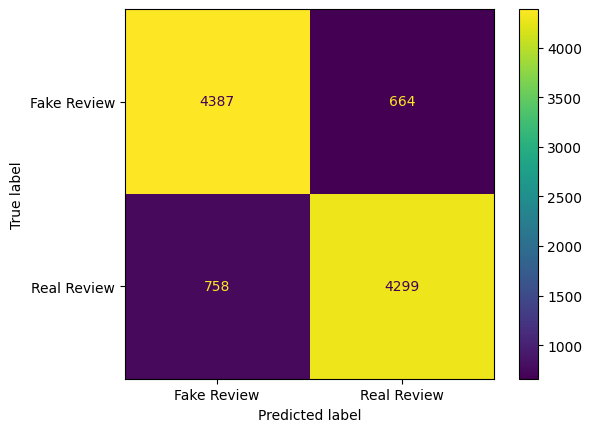

In [4]:
def linguistics_analysis(blob):
    """This function receives a TextBlob object and returns its subjectivity and polarity."""
    subjectivity = blob.subjectivity
    polarity = blob.polarity

    return subjectivity, polarity

def load_data():
    """This function loads data from a CSV file called "fake_reviews_dataset.csv". It returns the text reviews, labels, and the subjectivity and polarity of the reviews as separate lists."""
    text = []
    y = []
    subjectivities = []
    polarities = []

    try:
        with open("fake_reviews_dataset.csv", "r") as file:
            reader = csv.reader(file)
            next(reader)
            for row in tqdm(reader, total = 40432):
                label = row[2]
                review_text = row[3]

                # Mapping the label values to binary labels (0 for fake and 1 for real)
                if label == "OR":
                    label = 1
                else:
                    label = 0

                # Adding the review text and label to their respective lists
                text.append(review_text)
                y.append(label)

                # Analyzing the linguistic features of the review
                blob = TextBlob(review_text)
                subjectivity, polarity = linguistics_analysis(blob)

                # Adding the subjectivity and polarity values to their respective lists
                subjectivities.append(subjectivity)
                polarities.append(polarity)

        # Storing the subjectivity and polarity values in a separate list
        reviews_analysis = [subjectivities, polarities]
        return text, y, reviews_analysis

    except FileNotFoundError:
        print("Error, CSV file does not exist.")
    except Exception as e:
        print("Error, unable to load CSV file.")
        return None, None, None

def run_model(clf, x, y, model_name):
    """This function trains a classifier model on the input data and returns a dictionary with the details of the model."""
    # Splitting the data into training and testing sets
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size = .25)
    
    # Fitting the classifier model to the training data
    clf = clf.fit(x_train, y_train)

    # Making predictions on the test data
    predictions = clf.predict(x_test)

    # Calculating and print accuracy score of the model
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print(f"{model_name} Accuracy: {accuracy}")
    
   # Storing the model details in a dictionary for predicting highest accuracy
    model_data = dict(model_name = model_name, clf = clf, x_test = x_test, y_test = y_test, accuracy = accuracy)

    # Saving the trained model to disk
    joblib.dump(clf, f"{model_name}.joblib")

    return model_data

def print_best_model(model_data):
    """This function takes in a list of model data and prints the details of the model with the highest accuracy."""
    highest_accuracy = 0
    best_model = None

    # Finding the model with the highest accuracy score
    for model in model_data:
        if model["accuracy"] > highest_accuracy:
            highest_accuracy = model["accuracy"]
            best_model = model

    # Extracting the details of the best model
    model_name = best_model["model_name"]
    clf = best_model["clf"]
    x_test = best_model["x_test"]
    y_test = best_model["y_test"]
    predictions = clf.predict(x_test)

    # Displaying the classification report and confusion matrix of the best model
    print("")
    print(f"{model_name} Classification Report")
    print(sklearn.metrics.classification_report(y_test, predictions, target_names = ["Fake Review", "Real Review"]))

    print(f"{model_name} Confusion Matrix")
    cm = sklearn.metrics.confusion_matrix(y_test, predictions)
    disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels = ["Fake Review", "Real Review"])
    disp.plot()
    plt.show()

def main():
    """This script loads and processes data from "fake_reviews_dataset.csv", trains three ML models to classify reviews as fake/real using "linguistics_analysis", "load_data", "run_model", and "print_best_model" functions. Libraries used include langdetect, nltk, joblib, matplotlib, and sklearn."""
    print("Loading Data:")
    text, y, reviews_analysis = load_data()

    # Vectorizing the text reviews using CountVectorizer and combining them with the linguistic features
    vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words=stopwords.words("english"), max_features=1000)
    vectors = vectorizer.fit_transform(text)
    x = vectors.toarray()

    # Adding the linguistic features to the feature matrix
    x_list = x.tolist()
    for j, list_i in enumerate(x_list):
        list_i.append(reviews_analysis[0][j])
        list_i.append(reviews_analysis[1][j])
        x_list[j] = list_i

    x = np.array(x_list)

    # Training the machine learning models and selecting the best model
    print("")
    print("Model Accuracy:")
    model_data = [
        run_model(sklearn.tree.DecisionTreeClassifier(), x, y, "Decision Tree"),
        run_model(sklearn.neighbors.KNeighborsClassifier(201), x, y, "KNN"),
        run_model(sklearn.neural_network.MLPClassifier(), x, y, "Neural Network")
    ]

    print_best_model(model_data)

if __name__ == "__main__":
    main()
    